# Import Packages

Note : Hanya modeling menggunakan EX42 dan 44, HM Calculation di hilangkan outlier

In [1]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Import Raw Data

## Raw Data Fuel

In [2]:
fuel_raw = pd.read_excel('../data/processed/all_completed.xlsx')

fuel_raw.sample(10)

,code_unit,EGI,tipe,date,hour,SLOC,amount,Hm,Consumption,HM
1280,EX42,EGI 37,day,2022-09-26,11:56:00,CN403,1126.0,28193.0,147.000000,9.0
2612,EX44,EGI 87,day,2022-07-16,12:05:00,CN403,1041.0,22734.0,98.083333,12.0
313,EX41,EGI 37,day,2022-06-05,11:30:00,CN404,906.0,25093.0,12.000000,10.0
997,EX42,EGI 37,day,2022-05-09,14:46:00,CN404,775.0,25965.0,71.750000,8.0
2806,EX44,EGI 87,night,2022-10-20,00:19:00,CN404,1077.0,23946.0,90.727273,11.0
1546,EX43,EGI 87,night,2022-02-03,23:59:00,CN403,984.0,22203.0,101.777778,9.0
2335,EX44,EGI 87,day,2022-02-28,12:35:00,CN403,936.0,20291.0,90.000000,11.0
2134,EX43,EGI 87,night,2022-11-21,00:32:00,CN403,902.0,27151.0,143.888889,9.0
1453,EX42,EGI 37,night,2022-12-20,00:49:00,CN403,899.0,29738.0,162.666667,9.0
1549,EX43,EGI 87,day,2022-02-05,11:59:00,CN403,952.0,22236.0,48.181818,11.0


In [3]:
fuel_interim = fuel_raw.groupby(['code_unit',
                                 'date']).agg({'amount':np.sum,
                                               'HM':np.sum,
                                               'Consumption':np.mean}).reset_index().copy()

In [4]:
fuel_interim.sample(10)

,code_unit,date,amount,HM,Consumption
531,EX42,2022-06-16,2220.0,19.0,122.085227
904,EX43,2022-06-24,1635.0,18.0,94.112500
704,EX42,2022-12-06,2089.0,5.0,295.000000
477,EX42,2022-04-23,1682.0,16.0,127.126984
266,EX41,2022-09-24,954.0,15.0,63.600000
792,EX43,2022-03-04,1922.0,8.0,64.875000
994,EX43,2022-09-22,2073.0,10.0,101.300000
758,EX43,2022-01-29,1524.0,15.0,149.600000
615,EX42,2022-09-08,1233.0,16.0,71.200000
1294,EX44,2022-07-19,2063.0,22.0,93.391667


## Raw Data Production

In [5]:
production = pd.read_excel('../data/processed/Produksi EX41 dan EX43.ods')

production.sample(10)

,date,Eq. Numb,EGI,HM,Production OB
425,2022-09-15,EX43,Excavator,19.0,10750.0
452,2022-10-07,EX41,Excavator,16.0,6321.0
457,2022-10-09,EX43,Excavator,13.0,5633.0
498,2022-10-30,EX41,Excavator,19.0,8023.0
325,2022-07-27,EX43,Excavator,22.0,9570.0
101,2022-02-21,EX43,Excavator,22.0,9988.0
475,2022-10-18,EX43,Excavator,19.0,7869.0
320,2022-07-25,EX41,Excavator,21.0,9874.5
10,2022-01-07,EX41,Excavator,22.0,12195.0
504,2022-11-02,EX41,Excavator,15.0,5372.0


In [6]:
production_interim = production[['date',
                                 'Eq. Numb',
                                 'HM',
                                 'Production OB']].copy()

In [7]:
production_interim.rename(columns={"Eq. Numb": "code_unit"}, inplace=True)

In [8]:
production_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           718 non-null    datetime64[ns]
 1   code_unit      718 non-null    object        
 2   HM             718 non-null    float64       
 3   Production OB  718 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 22.6+ KB


In [9]:
production_interim.sample(10)

,date,code_unit,HM,Production OB
76,2022-02-09,EX41,16.0,8360.0
111,2022-02-26,EX43,18.0,7566.0
655,2023-01-16,EX43,2.0,0.0
378,2022-08-23,EX41,16.0,7785.0
463,2022-10-12,EX43,17.0,8342.0
168,2022-03-27,EX41,22.0,10076.0
197,2022-04-10,EX43,13.0,6178.0
8,2022-01-06,EX41,13.0,6255.0
579,2022-12-09,EX43,21.0,10062.0
310,2022-07-19,EX41,5.0,2728.0


In [10]:
production_interim['date'] = production_interim['date'].astype(str) 

## Raw Data Ritase

In [11]:
ritase_files = glob.glob('../data/processed/ritase_*.xls')

temp = []
for i in ritase_files:
      frame = pd.read_csv(i)
      frame['code_unit'] = i[25:29].upper()
      temp.append(frame)

ritase = pd.concat(temp, axis=0, ignore_index=True)

ritase['OB'] = ritase['ritase'] * 43

ritase

,date,ritase,code_unit,OB
0,2022-01-01,0,EX42,0
1,2022-01-02,135,EX42,5805
2,2022-01-03,149,EX42,6407
3,2022-01-04,159,EX42,6837
4,2022-01-05,135,EX42,5805
...,...,...,...,...
727,2022-12-28,211,EX44,9073
728,2022-12-29,164,EX44,7052
729,2022-12-30,255,EX44,10965
730,2022-12-31,192,EX44,8256


In [12]:
ritase_interim = ritase[['date', 'code_unit', 'OB']].copy()

In [13]:
ritase_interim.rename(columns={"OB": "Production OB"}, inplace=True)

In [14]:
ritase_interim.sample(10)

,date,code_unit,Production OB
292,2022-10-20,EX42,8170
256,2022-09-14,EX42,7998
175,2022-06-25,EX42,8428
332,2022-11-29,EX42,7697
327,2022-11-24,EX42,9718
407,2022-02-11,EX44,6364
492,2022-05-07,EX44,6708
78,2022-03-20,EX42,4816
423,2022-02-27,EX44,8557
129,2022-05-10,EX42,8901


In [15]:
ritase_interim.insert(2, 'HM', np.nan)

ritase_interim.sample(5)

,date,code_unit,HM,Production OB
416,2022-02-20,EX44,NaN,172
712,2022-12-13,EX44,NaN,9460
161,2022-06-11,EX42,NaN,13588
159,2022-06-09,EX42,NaN,7396
609,2022-09-01,EX44,NaN,8858


In [16]:
ritase_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           732 non-null    object 
 1   code_unit      732 non-null    object 
 2   HM             0 non-null      float64
 3   Production OB  732 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 23.0+ KB


In [17]:
production_final = pd.concat([production_interim, ritase_interim], 
                             axis=0, ignore_index=True)

production_final.sample(5)

,date,code_unit,HM,Production OB
838,2022-05-01,EX42,NaN,6106.0
156,2022-03-21,EX41,22.0,10956.0
1255,2022-06-21,EX44,NaN,7869.0
401,2022-09-03,EX43,20.0,8481.0
289,2022-07-08,EX43,21.0,10125.0


In [18]:
production_final

,date,code_unit,HM,Production OB
0,2022-01-02,EX41,20.0,10350.0
1,2022-01-02,EX43,21.0,10800.0
2,2022-01-03,EX41,22.0,11565.0
3,2022-01-03,EX43,21.0,9675.0
4,2022-01-04,EX41,14.0,6750.0
...,...,...,...,...
1445,2022-12-28,EX44,NaN,9073.0
1446,2022-12-29,EX44,NaN,7052.0
1447,2022-12-30,EX44,NaN,10965.0
1448,2022-12-31,EX44,NaN,8256.0


In [19]:
production_final['code_unit'].unique()

array(['EX41', 'EX43', 'EX42', 'EX44'], dtype=object)

## Finalize Data

In [20]:
fuel_interim.sample(5)

,code_unit,date,amount,HM,Consumption
342,EX41,2022-12-09,2342.0,21.0,102.040909
625,EX42,2022-09-18,1128.0,21.0,109.295455
693,EX42,2022-11-25,2550.0,20.0,80.200000
1392,EX44,2022-10-25,1262.0,3.0,320.000000
844,EX43,2022-04-25,1787.0,22.0,80.495726


In [21]:
production_interim.sample(5)

,date,code_unit,HM,Production OB
574,2022-12-07,EX41,16.0,6172.0
234,2022-06-09,EX41,17.0,8228.0
7,2022-01-05,EX43,22.0,12015.0
120,2022-03-03,EX41,0.0,0.0
713,2023-02-14,EX43,18.0,7009.0


In [22]:
df = pd.merge(fuel_interim, production_final, on=["date", "code_unit"],
              how='left')

In [23]:
df.columns = df.columns.str.upper() 

In [24]:
df.sample(5)

,CODE_UNIT,DATE,AMOUNT,HM_X,CONSUMPTION,HM_Y,PRODUCTION OB
1272,EX44,2022-06-27,1445.0,7.0,142.142857,NaN,989.0
434,EX42,2022-03-11,2203.0,20.0,103.700000,NaN,9159.0
1142,EX44,2022-02-17,999.0,26.0,58.337500,NaN,1935.0
786,EX43,2022-02-26,1467.0,17.0,94.650000,18.0,7566.0
1121,EX44,2022-01-27,2052.0,20.0,102.484848,NaN,10578.0


In [25]:
df.rename(columns={'HM_X': 'HM_CALC',
                   'HM_Y': 'HM_HRS',
                   'PRODUCTION OB' : "PRODUCTION_OB"}, inplace=True)

df.sample(5)

,CODE_UNIT,DATE,AMOUNT,HM_CALC,CONSUMPTION,HM_HRS,PRODUCTION_OB
512,EX42,2022-05-28,2140.0,20.0,110.737374,NaN,8686.0
529,EX42,2022-06-14,2470.0,21.0,122.363636,NaN,11739.0
10,EX41,2022-01-11,1645.0,7.0,150.857143,21.0,11520.0
662,EX42,2022-10-25,0.0,0.0,NaN,NaN,6493.0
678,EX42,2022-11-10,1744.0,14.0,152.625000,NaN,7009.0


In [26]:
df['CONSUMPTION_CALC'] = df['AMOUNT']/df['HM_CALC']

In [27]:
df['CONSUMPTION_HRS'] = df['AMOUNT']/df['HM_HRS']

In [28]:
df.sample(5)

,CODE_UNIT,DATE,AMOUNT,HM_CALC,CONSUMPTION,HM_HRS,PRODUCTION_OB,CONSUMPTION_CALC,CONSUMPTION_HRS
204,EX41,2022-07-24,2497.0,22.0,109.590909,NaN,NaN,113.500000,NaN
106,EX41,2022-04-17,0.0,11.0,73.090909,8.0,4657.0,0.000000,0.0
489,EX42,2022-05-05,2253.0,19.0,103.250000,NaN,9159.0,118.578947,NaN
120,EX41,2022-05-01,1514.0,15.0,120.829545,NaN,NaN,100.933333,NaN
60,EX41,2022-03-02,1706.0,16.0,164.881818,0.0,0.0,106.625000,inf


Amount : Konsumsi bahan bakar dalam liter (L)
Consumption : Konsumsi bahan bakar/jam (L/jam)

<AxesSubplot: ylabel='Frequency'>

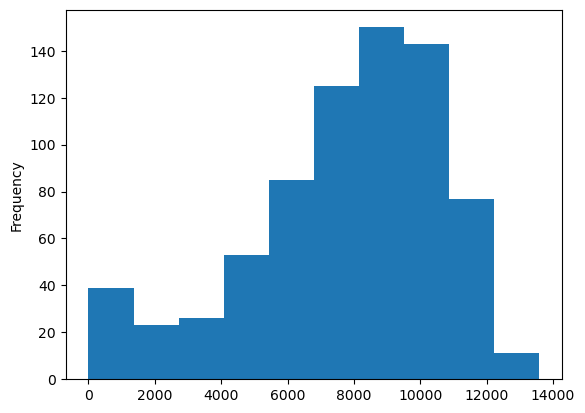

In [29]:
ritase_interim['Production OB'].plot(kind='hist') # OB hasil hitungan ritase

<AxesSubplot: ylabel='Frequency'>

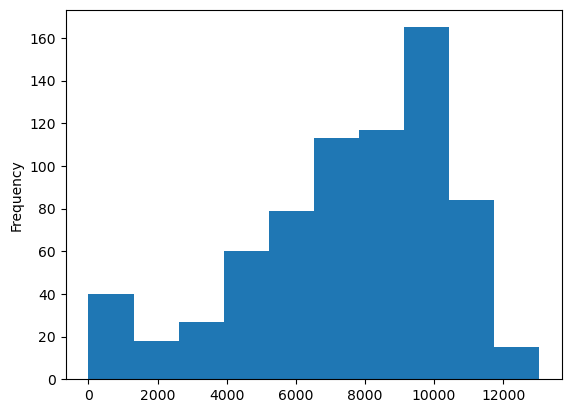

In [30]:
production_interim['Production OB'].plot(kind="hist")

# Modeling

In [123]:
df_modeling = df[['CODE_UNIT', 'AMOUNT', 'HM_CALC', 'PRODUCTION_OB']].copy()

In [124]:
df_modeling.dropna(inplace=True)

In [125]:
df_modeling = df_modeling[df_modeling['CODE_UNIT'].isin(['EX42', 'EX44'])].copy()

In [126]:
df_modeling = df_modeling[(df_modeling['AMOUNT'] > 0) & (df_modeling['PRODUCTION_OB'] > 0)]

In [127]:
df_modeling.shape

(656, 4)

In [128]:
df_modeling = df_modeling[(df_modeling['HM_CALC'] > 0) & (df_modeling['HM_CALC'] <= 24)]

In [129]:
df_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 366 to 1459
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CODE_UNIT      617 non-null    object 
 1   AMOUNT         617 non-null    float64
 2   HM_CALC        617 non-null    float64
 3   PRODUCTION_OB  617 non-null    float64
dtypes: float64(3), object(1)
memory usage: 24.1+ KB


In [130]:
df_modeling.replace([np.inf, -np.inf], np.nan, inplace=True)

In [131]:
df_modeling.dropna(inplace=True)

In [132]:
df_modeling['CODE_UNIT'].value_counts()

EX42    315
EX44    302
Name: CODE_UNIT, dtype: int64

In [133]:
df_modeling['ln_hm_calc'] = np.exp(df_modeling['HM_CALC'])
df_modeling['ln_amoount'] = np.exp(df_modeling['AMOUNT'])

c:\Users\asus\.miniconda3\envs\ds_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [134]:
df_modeling.corr(numeric_only=True)

,AMOUNT,HM_CALC,PRODUCTION_OB,ln_hm_calc,ln_amoount
AMOUNT,1.000000,0.514411,0.398769,0.135085,0.0
HM_CALC,0.514411,1.000000,0.440748,0.422521,0.0
PRODUCTION_OB,0.398769,0.440748,1.000000,0.127528,0.0
ln_hm_calc,0.135085,0.422521,0.127528,1.000000,NaN
ln_amoount,0.000000,0.000000,0.000000,NaN,NaN


<AxesSubplot: xlabel='AMOUNT', ylabel='HM_CALC'>

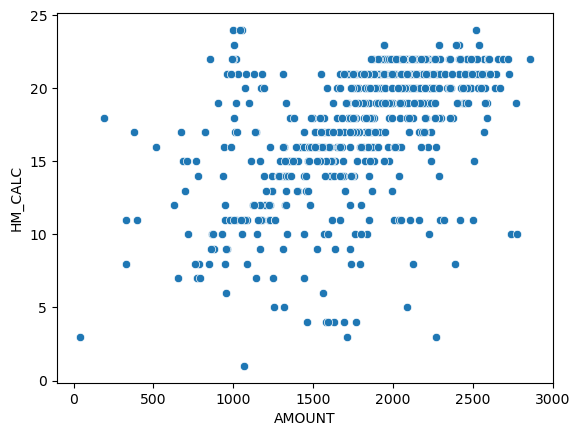

In [97]:
sns.scatterplot(df_modeling, x = 'AMOUNT', y='HM_CALC')

In [98]:
X = df_modeling.drop('HM_CALC', axis=1)
y = df_modeling['HM_CALC']

In [99]:
X = pd.get_dummies(X)

## Split Data

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
X_train

,AMOUNT,PRODUCTION_OB,CODE_UNIT_EX42,CODE_UNIT_EX44
1325,1894.0,2064.0,0,1
1147,949.0,4257.0,0,1
560,2466.0,11653.0,1,0
727,1770.0,8170.0,1,0
585,2491.0,9718.0,1,0
...,...,...,...,...
443,1769.0,4816.0,1,0
478,2135.0,8944.0,1,0
677,2360.0,11438.0,1,0
1222,1153.0,4644.0,0,1


## Preprocessing

In [102]:
scaler = StandardScaler()

In [103]:
numeric_feature = ['AMOUNT', 'PRODUCTION_OB']
categoric_feature = ['CODE_UNIT_EX42', 'CODE_UNIT_EX44']

scaler.fit(X_train[numeric_feature])

StandardScaler()

In [104]:
X_train_scaled = scaler.transform(X_train[numeric_feature])
X_test_scaled = scaler.transform(X_test[numeric_feature])

In [105]:
X_train_final = pd.concat([X_train[categoric_feature],
                           pd.DataFrame(X_train_scaled, index=X_train.index, columns=numeric_feature)], axis=1)

X_test_final = pd.concat([X_test[categoric_feature],
                           pd.DataFrame(X_test_scaled, index=X_test.index, columns=numeric_feature)], axis=1)

In [106]:
model = LinearRegression(n_jobs=-1)

In [107]:
X_train_final

,CODE_UNIT_EX42,CODE_UNIT_EX44,AMOUNT,PRODUCTION_OB
1325,0,1,0.182339,-2.355797
1147,0,1,-1.760241,-1.486327
560,1,0,1.358166,1.446005
727,1,0,-0.072560,0.065081
585,1,0,1.409557,0.678825
...,...,...,...,...
443,1,0,-0.074616,-1.264697
478,1,0,0.677749,0.371953
677,1,0,1.140268,1.360763
1222,0,1,-1.340891,-1.332891


In [94]:
y_train

1325    1894.0
1147     949.0
560     2466.0
727     1770.0
585     2491.0
         ...  
443     1769.0
478     2135.0
677     2360.0
1222    1153.0
474     2188.0
Name: AMOUNT, Length: 493, dtype: float64

In [108]:
import statsmodels.api as sm
mod = sm.OLS(y_train, X_train_final)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                HM_CALC   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     99.15
Date:                Sun, 12 Feb 2023   Prob (F-statistic):           3.83e-50
Time:                        15:21:44   Log-Likelihood:                -1320.1
No. Observations:                 493   AIC:                             2648.
Df Residuals:                     489   BIC:                             2665.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
CODE_UNIT_EX42    16.3006      0.227     71.

## Train Model

In [64]:
model.fit(X_train_final,y_train)

LinearRegression(n_jobs=-1)

In [65]:
y_train_predict = model.predict(X_train_final)
y_test_predict = model.predict(X_test_final)

In [66]:
model.coef_

array([ 61.08442405, -61.08442405,  30.29594551])

In [67]:
model.intercept_

1621.5680064304113

## Evaluation

In [68]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
from sklearn.metrics import f

In [69]:
train_rmse = mean_squared_error(y_train, y_train_predict, squared=False)
test_rmse = mean_squared_error(y_test, y_test_predict, squared=False)
train_mae = mean_absolute_error(y_train, y_train_predict)
test_mae = mean_absolute_error(y_test, y_test_predict)
train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)

print("Linear Regression")
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train R2", train_r2)
print("Test R2", test_r2)

Linear Regression
Train RMSE: 552.3079514588804
Test RMSE: 557.1656311135862
Train MAE: 437.8311382095395
Test MAE: 448.55624160057744
Train R2 0.014390213841331323
Test R2 -0.014074599064602067


# Export Dataset

In [55]:
df.to_csv("../data/processed/datamart_final.csv", index=False)